In [2]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [3]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grid = grid.merge(df[['grid_index','x','y']], on='grid_index', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_index']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_index'], keep='first')

# check on fractional overlap distribution
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < 0.05]['grid_index'].count() # less than 5% spatial overlap
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with < 5% fractional overlap.")
grid = grid[grid['overlap'] >= 0.05] # remove these observations


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y'],
      dtype='object')

Dropping [1395] duplicate grids.

Fractional overlap:
count    56767.000000
mean         2.029756
std          2.004417
min          0.000003
25%          0.591083
50%          1.498852
75%          2.779104
max         24.470760
Name: overlap, d

In [4]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the "tm_id" band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = tmid_da.shape, tmid_da.spatial_ref.GeoTransform, tmid_da.rio.crs, tmid_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {tmid_da[0].dtype}")

del treemap_da
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


28

In [5]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(tmid_da), 1, 0)
# calculate the total forested pixels
# see __functions.py 'compute_band_stats'
forest_pct = compute_band_stats(grid, forest_mask, 'grid_index', attr='constant')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
forest_pct = forest_pct[forest_pct['constant'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_index','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"\nSaved multi-band raster to: {out_fp}")

# Join to the grid data
grid = grid.merge(forest_pct, on='grid_index', how='left')
print(f"\n{grid.columns}")

print("\n~~~~~~~~~~~~~~~\n")
del forest_mask, forest_pct
gc.collect() # clean up


[86.59%] predominantly forest grids.

   grid_index  forest_pixels  forest_pct
0     1955419            169       100.0
1     1955420            182       100.0
2     1955421            169       100.0

Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fir

16

## TreeMap Tree Table

Summary of the the TreeMap Tree Table information within forested grids identified above. Specifically, we can retrieve an estimate of aspen abundance that goes beyond the algorithmic forest type code assigned to a pixel. In this, we can infer understory/overstory compositions potential to that area.

In [6]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_trees = compute_band_stats(grid, tmid_da, 'grid_index', attr='tm_id')

# tidy columns in the summary table
grid_trees['count'] = grid_trees['count'].astype(int)
grid_trees['total_pixels'] = grid_trees['total_pixels'].astype(int)
grid_trees.rename(columns={
    'count': 'tmid_count',
    'pct_cover': 'tmid_pct'
}, inplace=True)

# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join the Tree Table to the grid data
grid_trees = grid_trees.merge(tree_tbl, on='tm_id', how='left')
print(f"\n{grid_trees.head(12)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del tmid_da, tree_tbl # clean up 
gc.collect()

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')

    grid_index  tm_id  tmid_count  total_pixels  tmid_pct            CN  \
0      1955419   5081           2           169  1.183432  3.536933e+13   
1      1955419   5081           2           169  1.183432  3.536933e+13   
2      1955419   5081           2           169  1.183432  3.536933e+13   
3      1955419   5081           2           169  1.183432  3.536933e+13   
4      1955419   5081           2           169  1.183432  3.536933e+13   
5      1955419   5081           2           169  1.183432  3.536933e+13   
6      1955419   5081           2           169  1.183432  3.536933e+13   
7      1955419   5081           2           169  1.183432  3.536933e+13   
8      1955419   5081           2           169  1.183432  3.536933e+13   
9      1955419   5081           2           169

44

In [7]:
# Calculate the Shannon diversity index for each tm_id
# Using the full list of trees in the Tree Table
# Based on total trees per tm_id and proportion
df = grid_trees.copy()
df['total_trees'] = df.groupby('tm_id')['TREE'].transform('sum')
df['p_species'] = df['TREE'] / df['total_trees'] # proportion
# Calculate Shannon diversity (H') for each tree row
df['shannon_h'] = -df['p_species'] * np.log(df['p_species'])

# Aggregate to calculate H' at the tm_id level
shannon_tmid = (
    df.groupby('tm_id', as_index=False)
    .agg(shannon_h=('shannon_h', 'sum')))
# subset columns
shannon_tmid = shannon_tmid[['tm_id','shannon_h']]
print(shannon_tmid.head(3))

# merge back to the grid data
grid_trees = grid_trees.merge(shannon_tmid, on='tm_id', how='left')
print(f"\n{grid_trees.columns}")

del shannon_tmid, df
gc.collect()

   tm_id  shannon_h
0     32   5.455337
1    845   4.065466
2   1207   5.820758

Index(['grid_index', 'tm_id', 'tmid_count', 'total_pixels', 'tmid_pct', 'CN',
       'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME', 'SCIENTIFIC_NAME',
       'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR', 'SUBP', 'TREE',
       'AGENTCD', 'shannon_h'],
      dtype='object')


0

In [8]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)

grid_trees = grid_trees.merge(grid[['grid_index','forest_pixels','forest_pct']], on='grid_index', how='left')

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# tidy the live/dead column
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# calculate the trees per acre, scaling by the acre/pixel factor
grid_trees['tree_tpa'] = (grid_trees['TREE'] * grid_trees['TPA_UNADJ']) * 0.222395 # trees/pixel
# calculate live basal area (balive) scaled by TPA
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['tree_tpa']  # adjust based on tree abundance

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        tmid_pixels=('tmid_count','max'), # retains the tm_id pixel count
        tmid_pct=('tmid_pct','max'), # retain the percent of forested area
        forest_pixels=('forest_pixels','max'), # retain forest pixel count
        forest_pct=('forest_pct','max'), # retain forest percent for the grid
        shannon_h=('shannon_h','max'), # retains the tm_id shannon index
        balive=('BA_TPAsc', 'sum'),    # total BALIVE
        tpa_live=('tree_tpa', 'sum'),  # total live tree count (trees/acre)
        tree_ht_live=('ACTUALHT','mean') # average tree height
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        badead=('BA_TPAsc', 'sum'),    # Live basal area
        tpa_dead=('tree_tpa', 'sum'),  # Total live tree count (trees/acre)
        tree_ht_dead=('ACTUALHT','mean') # average tree height
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_index', 'tm_id', 'species'], 
    how='outer'
).fillna(0)
# total acres for the tm_id (pixels * conversion factor)
tree_metrics['tmid_acres'] =  tree_metrics['tmid_pixels'] * 0.222395 
# subset to the tree metric columns
tree_metrics = tree_metrics[['grid_index','tm_id','tmid_pixels','tmid_acres',
                             'tmid_pct','forest_pct','species','shannon_h',
                             'balive','badead','tpa_live','tpa_dead',
                             'tree_ht_live','tree_ht_dead']]

# Add a "combined TPA" (live + dead)
# this may be important for lodgepole and spruce-fir in particular (beetle-kill)
tree_metrics['tpa_ld'] = tree_metrics['tpa_live'] + tree_metrics['tpa_dead']
tree_metrics['ba_ld'] = tree_metrics['balive'] + tree_metrics['badead']

# filter out any rows with missing information
tree_metrics = tree_metrics[tree_metrics['tmid_pixels'] > 0]
print(f"\n{tree_metrics.head(12)}\n")
del live_metrics, dead_metrics, grid_trees
gc.collect()


    grid_index  tm_id  tmid_pixels  tmid_acres  tmid_pct  forest_pct  \
0        34602   3897          8.0    1.779160  4.419890   99.450549   
1        34602   3897          8.0    1.779160  4.419890   99.450549   
2        34602   3897          8.0    1.779160  4.419890   99.450549   
3        34602   4118          1.0    0.222395  0.552486   99.450549   
4        34602   4118          1.0    0.222395  0.552486   99.450549   
7        34602   4121          7.0    1.556765  3.867403   99.450549   
8        34602   4870          5.0    1.111975  2.762431   99.450549   
9        34602   4870          5.0    1.111975  2.762431   99.450549   
10       34602   4876          4.0    0.889580  2.209945   99.450549   
11       34602   9611          3.0    0.667185  1.657459   99.450549   
12       34602   9611          3.0    0.667185  1.657459   99.450549   
13       34602   9937          1.0    0.222395  0.552486   99.450549   

                        species  shannon_h        balive      

0

In [9]:
# drop rows with 0 tm_id
tree_metrics = tree_metrics[tree_metrics['tmid_pixels'] != 0]

In [10]:
unique_spp = tree_metrics['species'].unique()
unique_spp

array(['gambel oak', 'ponderosa pine', 'quaking aspen',
       'common or two-needle pinyon', 'oneseed juniper', 'utah juniper',
       'jeffrey pine', 'singleleaf pinyon', 'california black oak',
       'canyon live oak', 'douglas-fir', 'incense-cedar', 'white fir',
       'western juniper', 'alligator juniper', 'rocky mountain juniper',
       'sugar pine', 'loblolly pine', 'loblolly-bay', 'longleaf pine',
       'redbay', 'slash pine', 'swamp tupelo', 'sweetbay', 'water oak',
       'arizona white oak', 'emory oak', 'california live oak',
       'lodgepole pine', 'chokecherry', 'western larch',
       'california red fir', 'western white pine', 'engelmann spruce',
       'subalpine fir', 'narrowleaf cottonwood', 'plains cottonwood',
       'pondcypress', 'eastern redcedar', 'green ash',
       'eastern cottonwood', 'bur oak', 'other or unknown live tree',
       'peachleaf willow', 'willow spp.', 'black cottonwood',
       'arizona pinyon pine', 'pacific dogwood',
       'curlleaf m

In [11]:
[s for s in unique_spp if 'pine' in str(s).lower()] # check pine species

['ponderosa pine',
 'jeffrey pine',
 'sugar pine',
 'loblolly pine',
 'longleaf pine',
 'slash pine',
 'lodgepole pine',
 'western white pine',
 'subalpine fir',
 'arizona pinyon pine',
 'knobcone pine',
 'mexican pinyon pine',
 'southwestern white pine',
 'arizona pine',
 'washoe pine',
 'whitebark pine',
 'gray or california foothill pine',
 'limber pine',
 'great basin bristlecone pine',
 'rocky mountain bristlecone pine',
 'eastern white pine',
 'jack pine',
 'sand pine',
 'shortleaf pine',
 'chihuahuan pine',
 'virginia pine',
 'spruce pine',
 'pond pine',
 'red pine']

In [12]:
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape
spp_pr = (
    tree_metrics.groupby('species', as_index=False)
    .agg(
        balive=('balive', 'sum'),
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpa_live', 'sum'),
        tpa_ld=('tpa_ld', 'sum') # live+dead
    )
)
# calculate the fractions for both BALIVE and TPA
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['ba_ld_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum() # live+dead
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
spp_pr['tpa_ld_f'] = spp_pr['tpa_ld'] / spp_pr['tpa_ld'].sum() # live+dead
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_ld_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['ba_ld_f_csum'] = spp_pr['ba_ld_f'].cumsum() # live+dead
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
spp_pr['tpa_ld_f_csum'] = spp_pr['tpa_ld_f'].cumsum() # live+dead

metric = 'ba_ld_f_csum'
top_species = spp_pr[spp_pr[metric] <= 0.97]
print(f"\nSpecies making up 97% of *{metric}*: \n\n{top_species[['species','ba_ld','tpa_ld']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of *ba_ld_f_csum*: 

                        species         ba_ld        tpa_ld
132              ponderosa pine  8.215814e+10  1.485422e+09
99               lodgepole pine  3.995225e+10  2.526020e+09
80                    grand fir  2.505442e+10  5.739859e+08
64                  douglas-fir  1.733971e+10  4.205645e+08
200                   white fir  1.034557e+10  3.096052e+08
92                 jeffrey pine  1.015344e+10  1.381420e+08
171               subalpine fir  7.768531e+09  5.127430e+08
195             western juniper  7.525753e+09  1.160968e+08
74             engelmann spruce  5.814654e+09  2.767533e+08
135               quaking aspen  3.180585e+09  1.558954e+08
89                incense-cedar  3.056684e+09  4.666942e+07
196               western larch  2.842973e+09  9.658518e+07
62   curlleaf mountain-mahogany  2.348913e+09  5.163807e+07
78                   gambel oak  1.273097e+09  2.493940e+08
185                utah juniper  7.728395e+08  1.493251e

0

In [13]:
# Assess the species co-occurrence matrix to look for natural groupings
# Tests the "commonness" of species pairings
# Particularly, what to do with the "mixed conifers"
from itertools import combinations
from collections import Counter

# 1. Filter Tree Table to relevant species (most common)
spp_filter = ['white fir', 'grand fir', 'douglas-fir', 'engelmann spruce', 'subalpine fir']
top_spp_df = tree_metrics[tree_metrics['species'].str.lower().isin(spp_filter)]
# 2. Group species by tm_id
spp_tmid = (
    top_spp_df.groupby('tm_id')['species']
    .apply(lambda x: list(x.str.lower().unique()))  # Get unique species per tm_id
    .reset_index()
)
# 3. Generate all pairwise species combinations per tm_id
species_pairs = spp_tmid['species'].apply(
    lambda species_list: list(combinations(sorted(species_list), 2))
)
# Flatten list of all pairs
all_pairs = [pair for sublist in species_pairs for pair in sublist]
# 4. Count co-occurrences of each pair
pair_counts = Counter(all_pairs)
# Convert to DataFrame
pair_counts_df = (
    pd.DataFrame(pair_counts.items(), columns=['species_pair', 'coo_count'])
    .sort_values(by='coo_count', ascending=False)
)
# 5. Calculate co-occurrence percentage
total_tmid = len(spp_tmid)
pair_counts_df['coo_pct'] = pair_counts_df['coo_count'] / total_tmid * 100

# Inspect results
print(f"\n{pair_counts_df.head(30)}")

del spp_tmid, top_spp_df, species_pairs, pair_counts, pair_counts_df
gc.collect()


                        species_pair  coo_count    coo_pct
4  (engelmann spruce, subalpine fir)        609  22.105263
6           (douglas-fir, grand fir)        314  11.397459
1           (douglas-fir, white fir)        299  10.852995
0    (douglas-fir, engelmann spruce)        297  10.780399
3       (douglas-fir, subalpine fir)        223   8.094374
2      (engelmann spruce, white fir)         60   2.177858
8      (engelmann spruce, grand fir)         58   2.105263
7         (grand fir, subalpine fir)         29   1.052632
9             (grand fir, white fir)         16   0.580762
5         (subalpine fir, white fir)         11   0.399274


822

In [14]:
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'pinyon|juniper': 'Piñon-juniper',
    'engelmann spruce|subalpine fir': 'Spruce-fir',
    'ponderosa pine|jeffrey': 'Ponderosa', 
    'lodgepole pine': 'Lodgepole',
    'aspen': 'Aspen',
    'douglas-fir|grand fir|white fir': 'Mixed-conifer',
    'oak': 'Oak-woodland',
}

spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = tree_metrics[tree_metrics['species'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['species'].unique()})

# Apply the remap to create a new grouped species column
tree_metrics['species_gp_n'] = tree_metrics['species'].map(spp_remap).fillna(tree_metrics['species'])
# Verify the updated species groups
print(tree_metrics[['species', 'species_gp_n']].drop_duplicates().head(10))
print(f"\n{tree_metrics.columns}")

                        species   species_gp_n
0                    gambel oak   Oak-woodland
1                ponderosa pine      Ponderosa
2                 quaking aspen          Aspen
3   common or two-needle pinyon  Piñon-juniper
7               oneseed juniper  Piñon-juniper
9                  utah juniper  Piñon-juniper
11                 jeffrey pine      Ponderosa
12            singleleaf pinyon  Piñon-juniper
13         california black oak   Oak-woodland
14              canyon live oak   Oak-woodland

Index(['grid_index', 'tm_id', 'tmid_pixels', 'tmid_acres', 'tmid_pct',
       'forest_pct', 'species', 'shannon_h', 'balive', 'badead', 'tpa_live',
       'tpa_dead', 'tree_ht_live', 'tree_ht_dead', 'tpa_ld', 'ba_ld',
       'species_gp_n'],
      dtype='object')


In [15]:
# re-aggregate the TreeMap characteristics by FRP grid/species combinations
# summarizes forest metrics by individual species present in the grid cell
# now, summarizes against the new forest groups made above
grid_tm = (
    tree_metrics.groupby(
        ['grid_index', 'species_gp_n'], as_index=False
    ).agg(
        tmid_n=('tm_id', 'nunique'), # number of unique tm_id contributing
        forest_pct=('forest_pct','max'), # retains the forest pixel count for the grid
        shannon_h=('shannon_h','mean'),
        balive=('balive', 'sum'),
        badead=('badead', 'sum'), 
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpa_live', 'sum'),  
        tpa_dead=('tpa_dead', 'sum'),
        tpa_ld=('tpa_ld', 'sum'),
        tree_ht_live=('tree_ht_live', 'mean'),
        tree_ht_dead=('tree_ht_dead', 'mean')
    )
)

# Check results
print(f"\n{grid_tm.head(10)}\n")

del tree_metrics
gc.collect()


   grid_index   species_gp_n  tmid_n  forest_pct  shannon_h         balive  \
0       34602          Aspen       1   99.450549   7.168414     767.728006   
1       34602  Mixed-conifer       1   99.450549   7.674867  193050.923236   
2       34602   Oak-woodland       5   99.450549   7.979509   47521.494723   
3       34602  Piñon-juniper      12   99.450549   7.695326  327203.488306   
4       34602      Ponderosa       5   99.450549   8.580590  101746.724302   
5       34602  incense-cedar       1   99.450549   7.674867   29808.410179   
6       34603          Aspen       1   98.816568   7.168414     767.728006   
7       34603  Mixed-conifer       4   98.816568   6.697676  422066.291959   
8       34603   Oak-woodland       7   98.816568   8.144275   60976.842351   
9       34603  Piñon-juniper      12   98.816568   7.888823  290756.124875   

         badead          ba_ld     tpa_live    tpa_dead       tpa_ld  \
0      0.000000     767.728006    25.429283    0.000000    25.429283

31

In [16]:
# Re-assess the primary species after the regrouping
spp_pr = (
    grid_tm.groupby('species_gp_n', as_index=False)
    .agg(
        balive=('ba_ld','sum'),
        tpa_live=('tpa_ld', 'sum')
    )
)

# calculate the fraction
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='balive_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
top_species = spp_pr[spp_pr['balive_f_csum'] <= 0.97]
print(
    f"\nSpecies making up 97% of the total *tpa_live_f_csum*: \n\n",
    f"{top_species[['species_gp_n','balive_f','tpa_live_f']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of the total *tpa_live_f_csum*: 

      species_gp_n  balive_f  tpa_live_f
5       Ponderosa  0.406144    0.224016
2   Mixed-conifer  0.232039    0.179944
1       Lodgepole  0.175778    0.348534
6      Spruce-fir  0.059762    0.108933
4   Piñon-juniper  0.044877    0.026817
0           Aspen  0.014000    0.021513
67  incense-cedar  0.013449    0.006439
3    Oak-woodland  0.013142    0.039567




0

In [17]:
# Subset the tree table metrics to retain those which match our FORTYPCD
spps = ['Ponderosa','Lodgepole','Spruce-fir','Aspen','Mixed-conifer','Piñon-juniper']
grid_tm_spp = grid_tm[grid_tm['species_gp_n'].isin(spps)]
print(f"{len(grid_tm_spp)} / {len(grid_tm)} with our predominant species.")
del grid_tm
gc.collect()

262253 / 588308 with our predominant species.


0

In [18]:
# check on the aspen composition
# how many grids have at least some aspen component?
spp_idx = grid_tm_spp[grid_tm_spp['species_gp_n'] == 'Aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_tm_spp[grid_tm_spp['grid_index'].isin(spp_idx)]
# check how many aspen gridcells there are
n_spp_grids = len(grid_aspen['grid_index'].unique())
print(f"{n_spp_grids} [{round(n_spp_grids/len(grid_tm_spp['grid_index'].unique())*100,1)}%] grids w/ any aspen")

39450 [73.1%] grids w/ any aspen


In [19]:
# Identify dominant species for each grid cell by 'balive' or 'tpa_live'
# print these summaries for all species
# percent of grids in which that species is dominant
metrics = ['tpa_ld', 'ba_ld']  # metrics to assess
for metric in metrics:
    print(f"\nDominance based on *{metric}*\n")
    dom_spp = (
        grid_tm_spp.groupby('grid_index', as_index=False)
        .apply(lambda df: df.loc[df[metric].idxmax()])
        .reset_index(drop=True))
    # print the dominance for each major forest type
    for spp in spps:
        # Filter for grid cells where species is dominant
        spp_dominant = dom_spp[dom_spp['species_gp_n'] == spp]
        # Count the number of grid cells with aspen dominance
        n_dom = len(spp_dominant['grid_index'].unique())
        # Print the results
        total_grids = len(grid_tm_spp['grid_index'].unique())
        spp_pct = round(n_dom / total_grids * 100, 1)
        print(f"\t~ {spp}: {n_dom} grids ({spp_pct}%)")
print("\n")
del dom_spp, spp_dominant
gc.collect()


Dominance based on *tpa_ld*

	~ Ponderosa: 15077 grids (27.9%)
	~ Lodgepole: 18266 grids (33.9%)
	~ Spruce-fir: 9091 grids (16.8%)
	~ Aspen: 1309 grids (2.4%)
	~ Mixed-conifer: 7254 grids (13.4%)
	~ Piñon-juniper: 2961 grids (5.5%)

Dominance based on *ba_ld*

	~ Ponderosa: 23246 grids (43.1%)
	~ Lodgepole: 12849 grids (23.8%)
	~ Spruce-fir: 6112 grids (11.3%)
	~ Aspen: 988 grids (1.8%)
	~ Mixed-conifer: 7743 grids (14.4%)
	~ Piñon-juniper: 3020 grids (5.6%)




0

In [20]:
grid_tm_spp.columns

Index(['grid_index', 'species_gp_n', 'tmid_n', 'forest_pct', 'shannon_h',
       'balive', 'badead', 'ba_ld', 'tpa_live', 'tpa_dead', 'tpa_ld',
       'tree_ht_live', 'tree_ht_dead'],
      dtype='object')

In [21]:
# filter to keep grids with our top/dominant species
# species groups making up 97% of gridcell area
# calculate how many grids are predominantly forested
n_forest = len(grid_tm_spp[grid_tm_spp['forest_pct'] > 50])
print(f"[{round(n_forest/len(grid_tm_spp)*100,2)}%] predominantly forested grids.\n")

# Get the grid-level dominance and abundance proportions by species
# calculate the total balive and tpa for the grids
grid_totals = (
    grid_tm_spp.groupby('grid_index', as_index=False)
    .agg(
        shannon_h_mn=('shannon_h', 'mean'),
        balive_total=('balive', 'sum'),
        badead_total=('badead', 'sum'),
        ba_ld_total=('ba_ld', 'sum'),
        tpa_live_total=('tpa_live', 'sum'),
        tpa_dead_total=('tpa_dead', 'sum'),
        tpa_ld_total=('tpa_ld', 'sum')
    )
)
# subset columns
grid_totals = grid_totals[['grid_index','balive_total','badead_total','ba_ld_total',
                           'tpa_live_total','tpa_dead_total','tpa_ld_total','shannon_h_mn']]
# merge back to the grid data
grid_tm_spp = grid_tm_spp.merge(grid_totals, on='grid_index', how='left')

# calculate the species proportions (for live/dead)
# dominance (live/dead basal area)
grid_tm_spp['sp_dominance_l'] = grid_tm_spp['balive'] / grid_tm_spp['balive_total']
grid_tm_spp['sp_dominance_d'] = grid_tm_spp['badead'] / grid_tm_spp['badead_total']
grid_tm_spp['sp_dominance_ld'] = grid_tm_spp['ba_ld'] / grid_tm_spp['ba_ld_total']

# abundance (live/dead TPA)
grid_tm_spp['sp_abundance_l'] = grid_tm_spp['tpa_live'] / grid_tm_spp['tpa_live_total']
grid_tm_spp['sp_abundance_d'] = grid_tm_spp['tpa_dead'] / grid_tm_spp['tpa_dead_total']
grid_tm_spp['sp_abundance_ld'] = grid_tm_spp['tpa_live'] / grid_tm_spp['tpa_live_total']

del grid_totals

# cheack on the results
grid_tm_spp[['grid_index','species_gp_n',
             'sp_dominance_l','sp_dominance_d','sp_dominance_ld',
             'sp_abundance_l','sp_abundance_d','sp_abundance_ld',
             'shannon_h_mn'
            ]].head()

[89.6%] predominantly forested grids.



,grid_index,species_gp_n,sp_dominance_l,sp_dominance_d,sp_dominance_ld,sp_abundance_l,sp_abundance_d,sp_abundance_ld,shannon_h_mn
0,34602,Aspen,0.001233,0.000000,0.001128,0.002980,0.000000,0.002980,7.779799
1,34602,Mixed-conifer,0.309988,0.282755,0.307672,0.350334,0.053451,0.350334,7.779799
2,34602,Piñon-juniper,0.525401,0.396263,0.514419,0.596255,0.893098,0.596255,7.779799
3,34602,Ponderosa,0.163378,0.320982,0.176780,0.050432,0.053451,0.050432,7.779799
4,34603,Aspen,0.000889,0.000000,0.000825,0.002080,0.000000,0.002080,7.535196


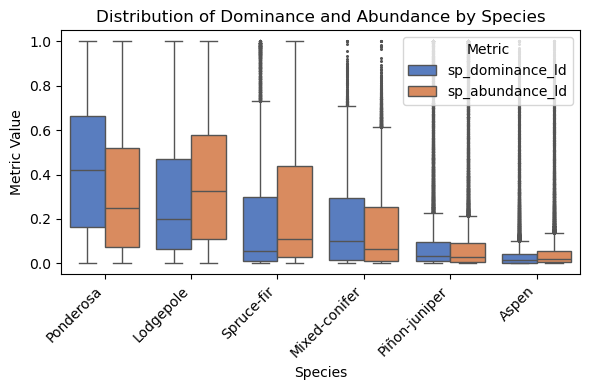

464

In [22]:
# Plot the distribution of dominance and abundance across forest species groups
# Sort species by mean dominance
sp_order = (
    grid_tm_spp.groupby('species_gp_n')['sp_dominance_ld']
    .mean().sort_values(ascending=False).index
)
# Reshape the data to long format for easier plotting
df_l = pd.melt(
    grid_tm_spp,
    id_vars=['species_gp_n'],
    value_vars=['sp_dominance_ld', 'sp_abundance_ld'],
    var_name='metric',
    value_name='value'
)

# Set up the plot
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df_l,
    x='species_gp_n',
    y='value',
    hue='metric',
    order=sp_order,
    palette='muted',
    flierprops=dict(marker='o', markersize=1.2)
)

# Customize the plot
plt.title('Distribution of Dominance and Abundance by Species')
plt.xlabel('Species')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

del df_l
gc.collect()

In [23]:
# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
grid_tm_spp.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_treetable.csv


In [ ]:
# merge back to the frp data
grid_tm_frp = grid.merge(grid_tm_spp, on='grid_index', how='inner')
grid_tm_frp.columns

# can just work with this one now
del grid_tm_spp
gc.collect()

In [ ]:
del grid_tm_spp
gc.collect()

In [ ]:
grid_tm_frp['species_gp_n'].unique()

In [ ]:
# Save this table out.
# First, extract centroid coords
df = grid_tm_frp.copy()
df = df.to_crs(4326) # WGS coords for lat/lon
df['grid_x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['grid_y'] = df.geometry.centroid.y 
# remove the geomtry field before exporting
df.drop(columns=['geometry'], inplace=True)

# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

del df
gc.collect()

In [ ]:
# Explore the data ...

In [ ]:
# plot the distribution of percent cover by forest types
grid_tm_frp['species_gp_n'] = grid_tm_frp['species_gp_n'].astype('category')

species_order = top_species['species_gp_n'].tolist()
grid_tm_frp['species_gp_n'] = pd.Categorical(
    grid_tm_frp['species_gp_n'],
    categories=species_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=grid_tm_frp,
    col='species_gp_n',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'sp_dominance_ld', fill=True, alpha=0.6)

# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Dominance (BALIVE)", "Density", size=9)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

# Show the plot
plt.show()

In [ ]:
# Species co-occurrence plot
# Threshold species presence where dominance/abundance > 1% of total
dt = 0.05
# Create a binary presence-absence matrix
pres_abs = (
    grid_tm_frp
    .pivot_table(index='grid_index', columns='species_gp_n', values='sp_dominance_ld', aggfunc='first')
    .fillna(0)
    .applymap(lambda x: 1 if x >= dt else 0)  # Convert to binary
)

# get the species names and matrix
species = pres_abs.columns
coo_mat = pd.DataFrame(0, index=species, columns=species)
# map across species combinations
for sp1, sp2 in combinations(species, 2):
    # Count co-occurrence (grids where both species are present)
    coo = np.sum(pres_abs[sp1] & pres_abs[sp2])
    coo_mat.loc[sp1, sp2] = coo
    coo_mat.loc[sp2, sp1] = coo  # Symmetry

# Optional: Normalize by the total number of grids for each species
species_totals = pres_abs.sum(axis=0)
norm_mat = coo_mat.div(species_totals, axis=0)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    norm_mat, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Co-Occurrence Frequency'}
)
plt.xlabel("Species")
plt.ylabel("Species")
plt.tight_layout()

out_png = os.path.join(projdir, 'figures/FigureX_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Plot maximum daytime FRP across dominance and abundance



In [ ]:
# Group by Conifer/Aspen
print(len(grid_tm_frp))
df = grid_tm_frp.copy()
df = df[df['species_gp_n'] != 'oak-woodland'] # remove the oak-woodland class
df['forest_phys'] = grid_tm_frp['species_gp_n'].apply(
    lambda x: 'conifer' if x != 'quaking aspen' else x)
print(df['forest_phys'].unique())
print(df['forest_phys'].value_counts())

In [ ]:
# create a 'conifer' column
df = grid_tm_frp.copy() # work with a copy
df = df[df['frp_max_day'] > 1] # filter out small FRP values

# label conifer/aspen, summarize percent cover
df['forest_phys'] = df['species_gp_n'].apply(lambda x: 'conifer' if x != 'quaking aspen' else x)
print(f"Forest classes: {df['forest_phys'].unique()}\n")

# aggregate statistics
df = (
    df.groupby(['grid_index', 'forest_phys'], as_index=False)
    .agg(
        ba_ld=('balive','sum'),
        tpa_ld=('tpa_live','sum'),
        abundance=('sp_abundance_ld','sum'),
        dominance=('sp_dominance_ld','sum')
    )
)

# filter to where there is some aspen or conifer
df = df[(df['abundance'] > 0)]

print(f"{len(df[df['forest_phys'] == 'quaking aspen'])} grids w/ some aspen.\n")
print(f"{df.head(3)}\n")

# Pivot to have one row per grid with aspen and conifer as columns
df_p = (
    df.pivot(index='grid_index', columns='forest_phys', values='dominance')
    .fillna(0)  # Fill missing values with 0
    .reset_index()
    .rename(columns={'quaking aspen': 'aspen', 'conifer': 'conifer'})
)

df_p['combined'] = df_p['aspen'] + df_p['conifer']
df_p = df_p[df_p['combined'] > 0.20] # greater than 50% combined dominance

# Add FRP metrics back to the DataFrame
df_p = df_p.merge(
    grid_tm_frp[['grid_index', 'frp_max_day']], on='grid_index', how='left'
)
print(f"{df_p.head(3)}\n")

# bin the data and plot the heatmap
bins = np.linspace(0, 1, 6)  # 10% intervals
df_p['aspen_bin'] = pd.cut(df_p['aspen'], bins, labels=bins[:-1])
df_p['conifer_bin'] = pd.cut(df_p['conifer'], bins, labels=bins[:-1])

# create the summarized data by bins (heatmap)
heatmap_da = df_p.groupby(['aspen_bin', 'conifer_bin']).frp_max_day.mean().unstack()
heatmap_da = heatmap_da.replace(0, np.nan)

# heatmap_da_log = np.log10(heatmap_da + 1e-6)

# plot it
plt.figure(figsize=(6, 4))

sns.heatmap(
    heatmap_da, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".0f", 
    cbar_kws={'label': 'Maximum FRP'}
)

plt.title("Aspen/Conifer Co-occurrence", size=12, loc='center')
plt.xlabel('Conifer (%)')
plt.ylabel('Aspen (%)')

out_plot = os.path.join(projdir, 'figures/FigureX_ConiferAspen_Heatmap_FRPmax_Tree.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# scaled tile version
# conifer/aspen
df = grid_forest.copy() # work with a copy

# label conifer/aspen, summarize percent cover
df['ForestPhys'] = df['SpeciesName'].apply(lambda x: 'Conifer' if x != 'Aspen' else x)
print(f" Forest classes: {df['ForestPhys'].unique()}\n")

# Recalculate percent cover
cover_df = (
    df.groupby(['grid_index', 'ForestPhys'])['spp_pct']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Aspen': 'aspen_pct', 'Conifer': 'conifer_pct'})
)

cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df['conifer_pct']
# cover_df = cover_df[cover_df['combined_pct'] > 60]

# Merge with FRP data
frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 
                     'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

# Bin Aspen and species percent cover
bins = np.linspace(0, 100, 11)  # 10% intervals
cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=bins[:-1])
cover_df['conifer_bin'] = pd.cut(cover_df['conifer_pct'], bins, labels=bins[:-1])

# Group by bins and calculate statistics
grouped = cover_df.groupby(['aspen_bin', 'conifer_bin'])
counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

# Merge statistics into a single DataFrame
tiles_df = pd.merge(counts, mean_frp, on=['aspen_bin', 'conifer_bin'])
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2

# create the plot
tiles_df['aspen_bin_idx'] = tiles_df['aspen_bin'].cat.codes
tiles_df['conifer_bin_idx'] = tiles_df['conifer_bin'].cat.codes

# get the KDE plot for aspen/conifer
kde_data = cover_df.melt(
    id_vars='grid_index', 
    value_vars=['aspen_pct', 'conifer_pct'], 
    var_name='species', 
    value_name='pct_cover'
)

# Rename for consistent labeling
kde_data['species'] = kde_data['species'].replace({
    'aspen_pct': 'Aspen', 
    'conifer_pct': 'Conifer'
})

In [ ]:
# 1. Prepare the data
# Filter data to remove non-forested or low-FRP grid cells
grid_tm_frp_nonzero = grid_tm_frp[grid_tm_frp['frp_max_day'] > 0]

# Compute the dominant species based on abundance and dominance
dominant_abundance = (
    grid_tm_frp_nonzero.loc[grid_tm_frp_nonzero.groupby('grid_index')['sp_abundance_ld'].idxmax()]
)
dominant_dominance = (
    grid_tm_frp_nonzero.loc[grid_tm_frp_nonzero.groupby('grid_index')['sp_dominance_ld'].idxmax()]
)

# Subset only rows with a significant contribution (threshold adjustable)
abundance_threshold = 0.5  # Example: At least 80% abundance
dominance_threshold = 0.5  # Example: At least 80% dominance

dom_abundance = dominant_abundance[dominant_abundance['sp_abundance_ld'] > abundance_threshold]
dom_dominance = dominant_dominance[dominant_dominance['sp_dominance_ld'] > dominance_threshold]

# Get sorted species order by FRP median
abundance_median = dom_abundance.groupby('species_gp_n')['frp_max_day'].median().sort_values(ascending=False)
dominance_median = dom_dominance.groupby('species_gp_n')['frp_max_day'].median().sort_values(ascending=False)

# Sort species names by FRP medians
abundance_sorted = abundance_median.index.tolist()
dominance_sorted = dominance_median.index.tolist()

# 2. Plot: Abundance-Based
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=dom_abundance,
    x='frp_max_day',
    y='species_gp_n',
    order=abundance_sorted,
    palette='coolwarm_r',
    fliersize=4,
    dodge=False
)
plt.xscale('log')  # Log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type (Abundance-Based)')
plt.title('FRP by Dominant Species (Abundance)')
plt.tight_layout()

# out_plot_abundance = os.path.join(projdir, 'figures/FigureX_ForestAbundance_FRPmax.png')
# plt.savefig(out_plot_abundance, dpi=300, bbox_inches='tight')
# print(f"\nSaved to: {out_plot_abundance}\n")

plt.show()

# 3. Plot: Dominance-Based
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=dom_dominance,
    x='frp_max_day',
    y='species_gp_n',
    order=dominance_sorted,
    palette='coolwarm_r',
    fliersize=4,
    dodge=False
)
plt.xscale('log')  # Log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type (Dominance-Based)')
plt.title('FRP by Dominant Species (Dominance)')
plt.tight_layout()

# out_plot_dominance = os.path.join(projdir, 'figures/FigureX_ForestDominance_FRPmax.png')
# plt.savefig(out_plot_dominance, dpi=300, bbox_inches='tight')
# print(f"\nSaved to: {out_plot_dominance}\n")

plt.show()

In [ ]:
# # Plot the influence of aspen composition on FRP
# # Conifer/Aspen dominance waffle chart

# # create bins for species composition
# bins = np.linspace(0, 100, 6) # 20% intervals
# spps = [s for s in grid_tm_frp['species_gp_n'].unique() if s != 'quaking aspen'] # exclude aspen from species list
# print(f"Associate forest type: {spps}\n")

# df = grid_tm_frp.copy() # work on a copy of the data

# # create grid data
# tiles = []  # Store tile data
# for sp in spps:
#     # Filter for co-occurrence
#     df_sp = df[df['species_gp_n'].isin(['Aspen', sp])]

#     # Pivot to create columns for Aspen and the species
#     cover_df = (
#         df_sp.pivot_table(index='grid_index', columns='species_gp_n', values='spp_pct', fill_value=0)
#         .reset_index()
#         .rename(columns={'Aspen': 'aspen_pct', sp: f'{sp}_pct'})
#     )

#     # make sure there is some of each kind
#     cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df[f'{sp}_pct']
#     cover_df = cover_df[cover_df['combined_pct'] > 50]

#     # Merge with FRP data
#     frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
#     cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

#     # Bin Aspen and species percent cover
#     cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=range(len(bins) - 1))
#     cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_pct'], bins, labels=range(len(bins) - 1))

#     # Group by bins and calculate statistics
#     grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
#     counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
#     mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

#     # Merge statistics into a single DataFrame
#     tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
#     tiled_data['species'] = sp
#     tiles.append(tiled_data)

# # Combine tile data
# tiles_df = pd.concat(tiles, ignore_index=True)
# tiles_df['log_frp'] = np.log10(tiles_df['frp'] + 1)

# # Normalize tile sizes (scale frequency)
# tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# # Plotting the tile-scaled heatmap
# n_cols = 3  # Number of columns in the facet grid
# n_rows = int(np.ceil(len(spps) / n_cols))
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,3.5), constrained_layout=True)
# axes = axes.flatten()

# vmin = tiles_df['log_frp'].min()
# vmax = tiles_df['log_frp'].quantile()
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

# log_frp_min = np.percentile(tiles_df['log_frp'], 10)
# log_frp_max = np.percentile(tiles_df['log_frp'], 90)

# # make the grids
# for i, sp in enumerate(spps):
#     sp_data = tiles_df[tiles_df['species'] == sp]
#     ax = axes[i]

#     vmin = sp_data['frp'].min()
#     vmax = sp_data['frp'].max()

#     for _, row in sp_data.iterrows():
#         x = int(row[f'{sp}_bin'])  
#         y = int(row['aspen_bin'])  
#         size = row['tile_size'] * 0.9
        
#         norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
#         color = plt.cm.coolwarm(norm(row['frp']))
        
#         ax.add_patch(
#             plt.Rectangle(
#                 (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
#             )
#         )

#     # Formatting the axes
#     # ax.set_title(sp, size=10)
#     ax.text(
#         0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
#         transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
#         ha='right', va='top',  # Align the text to the top-right
#         fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
#     )
#     ax.set_xlabel(f'')
#     ax.set_ylabel('Aspen Cover (%)', size=9)
#     ax.set_xticks(range(len(bins) - 1))
#     ax.set_yticks(range(len(bins) - 1))
#     ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
#     ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
#     ax.set_xlim(-0.5, len(bins) - 1.5)
#     ax.set_ylim(-0.5, len(bins) - 1.5)

#     # sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
#     # cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.50, pad=0.1)
#     # cbar.set_label('Maximum FRP')

# sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
# cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
# cbar.set_label('Maximum FRP')
# cbar.set_label('Cumulative FRP', fontsize=10)
# cbar.ax.tick_params(labelsize=8)

# # Remove unused axes
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# del df

# out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Scaled.png')
# plt.savefig(out_plot, dpi=300, bbox_inches='tight')

# plt.show()